In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sopt.examples.utils import getSampleObj
from sopt.optimizers.tensorflow import Curveball, LMA

In [2]:
%load_ext autoreload
%autoreload 2

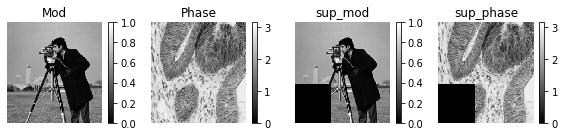

In [3]:
image = getSampleObj(256, phase_range=np.pi)
ft_mod = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(image), norm='ortho')))

var_shape = 100
sample_support = image.copy()
sample_support[:var_shape, :var_shape] = 0

plt.figure(figsize=[8,2])
figs = { 'Mod':np.abs(image), 'Phase':np.angle(image), 
        'sup_mod':np.abs(sample_support), 'sup_phase': np.angle(sample_support)}
for i, (key, val) in enumerate(figs.items()):
    plt.subplot(1,4,i+1)
    plt.pcolormesh(val, cmap='gray')
    plt.colorbar()
    plt.title(key)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
init_weights = np.ones(2 * var_shape * var_shape)
support_shape = sample_support.shape[0]
var_shape, support_shape

(100, 256)

In [31]:
tf.reset_default_graph()
tf_var = tf.get_variable('var', dtype=tf.float32, shape=[2 * var_shape**2], initializer=tf.ones_initializer)
tf_support = tf.constant(sample_support, dtype=tf.complex64, name='support')
tf_diffraction_mod = tf.constant(np.fft.fftshift(ft_mod).flatten(), dtype=tf.float32, name='diffractions')

def get_var_and_support(var):
    tf_var_reshaped = tf.reshape(var, [2, var_shape, var_shape])
    tf_var_cmplx = tf.complex(tf_var_reshaped[0], tf_var_reshaped[1])
    tf_var_padded = tf.pad(tf_var_cmplx, [[0,support_shape - var_shape], [0, support_shape - var_shape]])
    tf_var_and_support = tf_var_padded + tf_support
    return tf_var_and_support

def predictions_fn(var):
    tf_var_and_support = get_var_and_support(var)
    tf_fft_mod = tf.abs(tf.fft2d(tf_var_and_support)) / support_shape
    return tf.reshape(tf_fft_mod, [-1])

def loss_fn(predictions):
    return 0.5 * tf.reduce_sum((predictions - tf_diffraction_mod)**2)


loss_fn_tensor = loss_fn(predictions_fn(tf_var))
var_and_support = get_var_and_support(tf_var)

lma_opt = LMA(tf_var, predictions_fn, loss_fn, name='opt1', squared_loss=True)
min_op = lma_opt.minimize()  

In [32]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [33]:
for i in range(100):
    _, lossval = session.run([min_op, loss_fn_tensor])
    if i % 20 == 0: print(lossval)#, lossval2)

3700.2769


InvalidArgumentError: assertion failed: [Gradient norm lower than tolerance.] [Condition x > y did not hold element-wise:x (opt1_minimize_step/norm/Squeeze:0) = ] [8.02708882e-07] [y (opt1_minimize_step/assert_greater/y:0) = ] [1e-06]
	 [[node opt1_minimize_step/assert_greater/Assert/AssertGuard/Assert (defined at /raid/home/skandel/code/second_order_phase_retrieval/sopt/optimizers/tensorflow/lma.py:131) ]]
	 [[node opt1_minimize_step/add_2 (defined at /raid/home/skandel/code/second_order_phase_retrieval/sopt/optimizers/tensorflow/lma.py:202) ]]

Caused by op 'opt1_minimize_step/assert_greater/Assert/AssertGuard/Assert', defined at:
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3209, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-b3c34295b38c>", line 26, in <module>
    min_op = lma_opt.minimize()
  File "/raid/home/skandel/code/second_order_phase_retrieval/sopt/optimizers/tensorflow/lma.py", line 131, in minimize
    message='Gradient norm lower than tolerance.')
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tensorflow/python/ops/check_ops.py", line 943, in assert_greater
    return control_flow_ops.Assert(condition, data, summarize=summarize)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tensorflow/python/util/tf_should_use.py", line 193, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs))
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 168, in Assert
    guarded_assert = cond(condition, no_op, true_assert, name="AssertGuard")
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2108, in cond
    orig_res_f, res_f = context_f.BuildCondBranch(false_fn)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 1941, in BuildCondBranch
    original_result = fn()
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 166, in true_assert
    condition, data, summarize, name="Assert")
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tensorflow/python/ops/gen_logging_ops.py", line 72, in _assert
    name=name)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/raid/home/skandel/anaconda3/envs/ad/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): assertion failed: [Gradient norm lower than tolerance.] [Condition x > y did not hold element-wise:x (opt1_minimize_step/norm/Squeeze:0) = ] [8.02708882e-07] [y (opt1_minimize_step/assert_greater/y:0) = ] [1e-06]
	 [[node opt1_minimize_step/assert_greater/Assert/AssertGuard/Assert (defined at /raid/home/skandel/code/second_order_phase_retrieval/sopt/optimizers/tensorflow/lma.py:131) ]]
	 [[node opt1_minimize_step/add_2 (defined at /raid/home/skandel/code/second_order_phase_retrieval/sopt/optimizers/tensorflow/lma.py:202) ]]


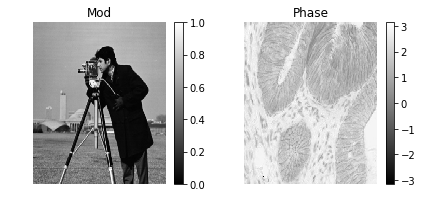

In [35]:
out = session.run(var_and_support)
plt.figure(figsize=[6,3])
figs = { 'Mod':np.abs(out), 'Phase':np.angle(out)}
for i, (key, val) in enumerate(figs.items()):
    plt.subplot(1,2,i+1)
    plt.pcolormesh(val, cmap='gray')
    plt.colorbar()
    plt.title(key)
    plt.axis('off')
plt.tight_layout()
plt.show()